In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import datetime, os
#%load_ext tensorboard


C:\Users\rayde\AppData\Local\Temp\ipykernel_12432\112365995.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )


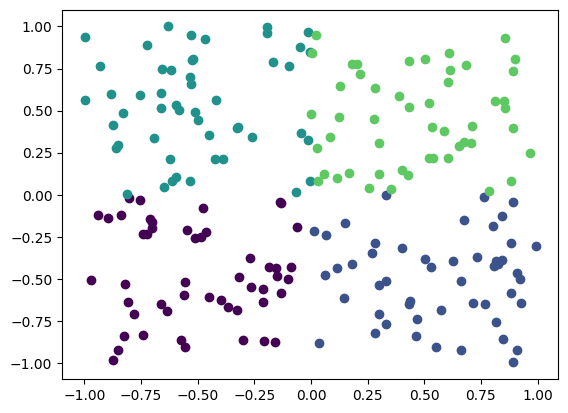

In [3]:
n_samples = 50
n_partitions = 2

random_samples = 2*np.random.rand(n_partitions**2, 2, n_samples)/n_partitions

# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, n_partitions, endpoint=False)
y = np.linspace(-1, 1, n_partitions, endpoint=False)
X,Y = np.meshgrid(x,y)
partitions = random_samples + np.stack([X.flatten(), Y.flatten()]).T[..., np.newaxis]
partitions = np.swapaxes(partitions, 1, 2)

cmap = plt.get_cmap('viridis') 

for i, part  in enumerate(partitions):
    plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )

C:\Users\rayde\AppData\Local\Temp\ipykernel_12432\1564516279.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )


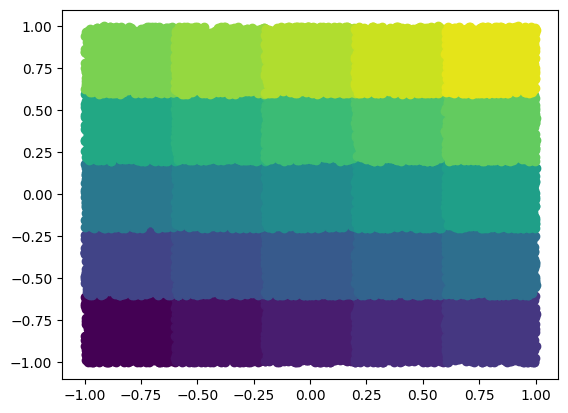

In [4]:
n_samples = 1000
n_partitions = 5

random_samples = 2*np.random.rand(n_partitions**2, 2, n_samples)/n_partitions

# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, n_partitions, endpoint=False)
y = np.linspace(-1, 1, n_partitions, endpoint=False)
X,Y = np.meshgrid(x,y)
partitions = random_samples + np.stack([X.flatten(), Y.flatten()]).T[..., np.newaxis]
partitions = np.swapaxes(partitions, 1, 2)

cmap = plt.get_cmap('viridis') 

for i, part  in enumerate(partitions):
    plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )

In [5]:
partitions.shape

(25, 1000, 2)

In [13]:
# Define vector function with three scalar functions
# def f_sum_decomposable(x):
#     x1, x2 = x[:,0], x[:,1]
#     return np.array([np.sin(4 * np.pi * x1) + np.sin(4 * np.pi * x2),
#             np.sin(3 * np.pi * ((x1-0.5)**2)) + np.cos(2*np.pi*((x2-0.5)**2)),
#             np.sin(6 * np.pi * (x1)**2) - np.sin(6 * np.pi * (x2)**2)]).T

def f_sum_decomposable(x):
    x1, x2 = x[:,0], x[:,1]
    #use booths funciton, beales function and rosebrock function with a=1 and b=100
    return np.array([8*x1**2 + 4*x2**2 + 3,
            (x1+2*x2-7)**2 + (2*x1+x2-5)**2,
            (1-x1)**2 + 100*(x2-x1**2)**2]).T

# Define vector function with three scalar functions
def f_prod(x):
    x1, x2 = x[:,0], x[:,1]
    return np.array([np.sin(4 * np.pi * x1) * np.sin(4 * np.pi * x2),
            np.sin(4 * np.pi * ((x1)**2+(x2)**2)),
            np.cos(3 * np.pi * (x1)**2) * np.cos(4 * np.pi * (x2)**2)]).T


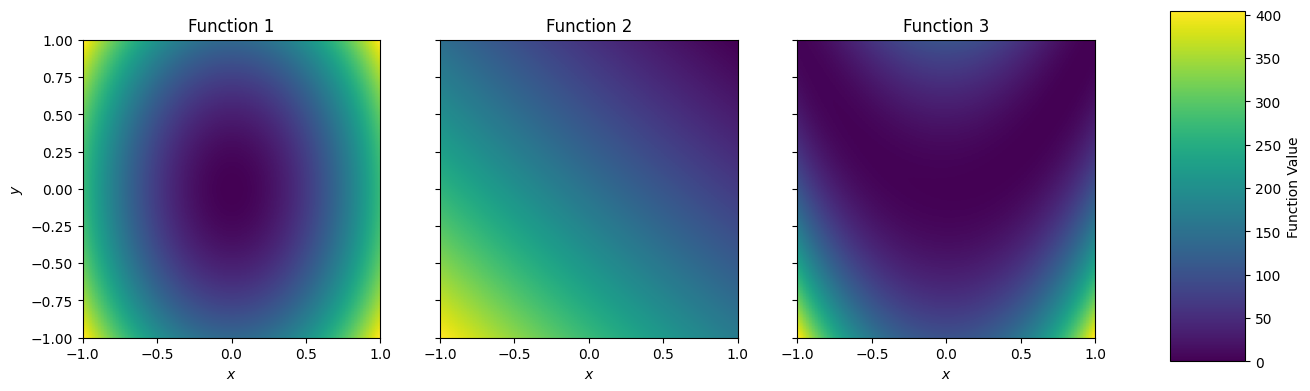

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T


f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

class ResNetLikeModel(tf.keras.Model):
    def __init__(self, input_dim, output_dim, depth, width):
        super(ResNetLikeModel, self).__init__()

        self.input_layer = layers.Dense(width)
        self.linear_layer = layers.Dense(output_dim)

        self.hidden_layers = [layers.Dense(width) for _ in range(depth)]
        self.output_layers = [layers.Dense(output_dim, use_bias=False) for _ in range(depth+1)]

    def apply_activation_with_scaling(self, x, scale_factor=1.0):
        z = scale_factor*x
        x1 = tf.nn.relu(z)
        x2 = tf.nn.relu(-z)
        return tf.concat([x1, x2], axis=-1)

    def call(self, inputs):
        accumulator = self.linear_layer(inputs)

        x = self.input_layer(inputs)
        x = self.apply_activation_with_scaling(x)
        accumulator += self.output_layers[0](x)

        for i, hidden_layer in enumerate(self.hidden_layers):
            x = tf.concat([inputs, accumulator, x], axis=1)
            x = hidden_layer(x)
            x = self.apply_activation_with_scaling(x, 1/((i+2)**2))
            accumulator += self.output_layers[i+1](x)

        return accumulator

# Test the model
model = ResNetLikeModel(input_dim=10, output_dim=1, depth=8, width=16)

# Create random input data
inputs = tf.random.normal(shape=(5, 10))

# Call the model on the inputs
outputs = model(inputs)

# Print the outputs
print(outputs)

tf.Tensor(
[[-1.2653018 ]
 [-0.32816768]
 [ 1.2088475 ]
 [-1.78438   ]
 [ 1.6154739 ]], shape=(5, 1), dtype=float32)


Model: "res_net_like_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            multiple                  96        
                                                                 
 dense_74 (Dense)            multiple                  9         
                                                                 
 dense_75 (Dense)            multiple                  2240      
                                                                 
 dense_76 (Dense)            multiple                  2240      
                                                                 
 dense_77 (Dense)            multiple                  2240      
                                                                 
 dense_78 (Dense)            multiple                  2240      
                                                                 
 dense_79 (Dense)            multiple         

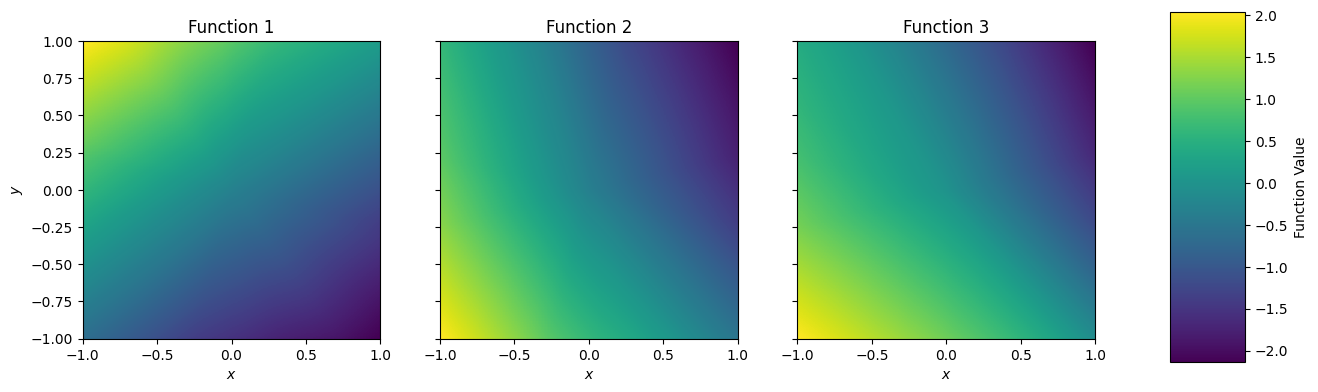

In [16]:
#Initialize your model
model = ResNetLikeModel(2, 3, 16, 32)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')

# Compute the function values at the grid points for each functions
Z_pred = np.array(model(coordinates))
model.summary()

Z_pred = Z_pred.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z_pred[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [17]:
np.random.shuffle(partitions.reshape(-1,2))

In [18]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Generate some dummy data for training
#np.random.seed(0)
#train_data = 2.0 * np.random.rand(10000, 2) - 1.0 #np.random.rand(10000, 2)

#flatten partitions to create a batch of all data
# must shuffle data, otherwise 1st epoch of training has non-uniformly distributed data
train_data = partitions.reshape(-1,2) 
np.random.shuffle(train_data)

train_labels = f(train_data)

# Fit the model to the data
history = model.fit(train_data, train_labels, batch_size=100,
          epochs=50)

Epoch 1/50
250/250 [==============================] - 3s 3ms/step - loss: 2487.5808
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 777.7654
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 653.3040
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 441.2504
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 135.6831
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 10.7202
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 4.9472
Epoch 8/50
250/250 [==============================] - 1s 3ms/step - loss: 3.5896
Epoch 9/50
250/250 [==============================] - 1s 3ms/step - loss: 2.9192
Epoch 10/50
250/250 [==============================] - 1s 3ms/step - loss: 2.6249
Epoch 11/50
250/250 [==============================] - 1s 3ms/step - loss: 2.3917
Epoch 12/50
250/250 [==============================] - 1s 3ms/step - loss: 2.1207
Epoch 13/50
2

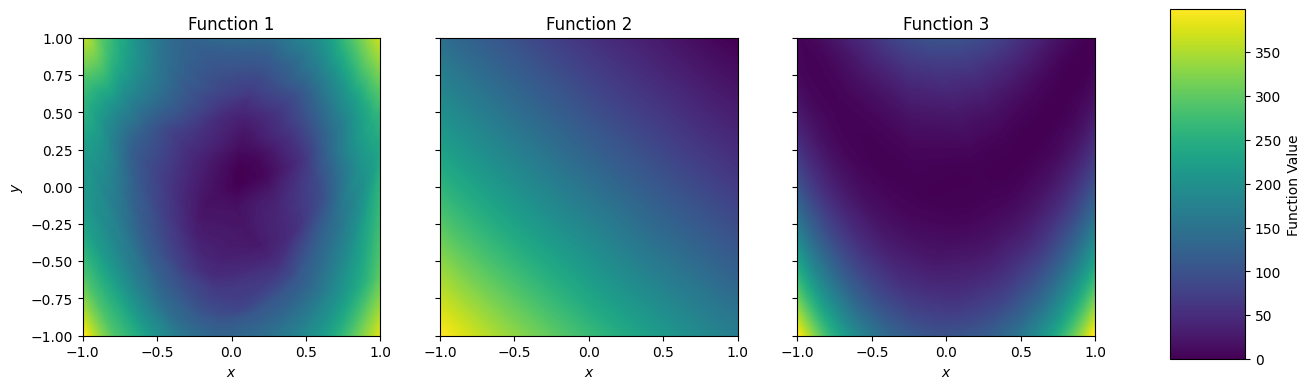

In [19]:
# Compute the function values at the grid points for each functions
Z_pred = np.array(model(coordinates))
#model.summary()

Z_pred = Z_pred.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z_pred[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()